<a href="https://colab.research.google.com/github/Stweel654/Steve_Tweel_STweel_64061-002/blob/main/Assignment%203/Assignment_3_Stephen_Tweel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 3 - Stephen Tweel

## A temperature-forecasting example

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-04-05 15:11:43--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.52.40, 52.216.39.8, 16.15.185.48, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.52.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  6.48MB/s    in 2.0s    

2025-04-05 15:11:46 (6.48 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Inspecting the data of the Jena weather dataset**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

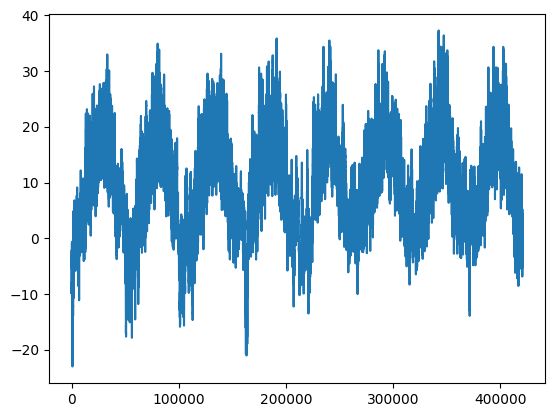

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

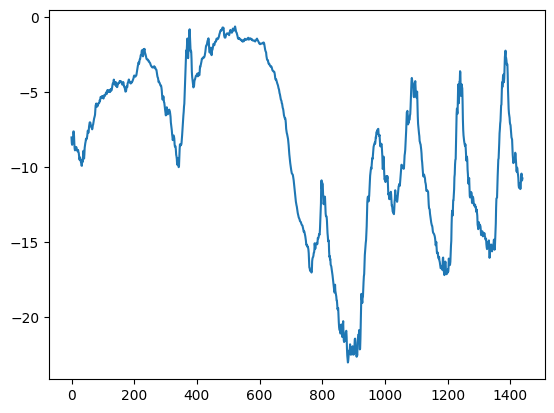

In [ ]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114
[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7
Input shape: (256, 120, 14)
Target shape: (256,)
Input shape: (256, 120, 14)
Target shape: (256,)
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - loss: 135.0508 - mae: 9.6572 - val_loss: 85.6819 - val_mae: 7.5347
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - loss: 72.4054 - mae: 6.7542 - val_loss: 58.5532 - val_mae: 5.9934
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 53.5983 - mae: 5.6392 - val_loss: 47.6639 - val_mae: 5.3675
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - loss: 41.3464 - mae: 4.8830 - val_loss: 41.6722 - val_mae: 5.0158
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/

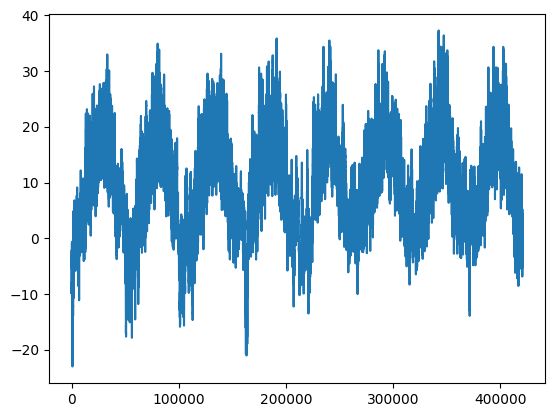

In [34]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
   layers.Input(shape=(120,14)),
   layers.LSTM(32),
   layers.Dense(1)
])

steps_per_epoch = 32

import os, shutil, pathlib
import numpy as np # Import numpy and assign it to the alias 'np'

#!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
#!unzip jena_climate_2009_2016.csv.zip

import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

import numpy as np
temperature = []
raw_data = []

for line in lines:
    if not line:
        continue
    values = [float(x) for x in line.split(",")[1:]]
    temperature.append(values[1])
    raw_data.append(values)

temperature = np.array(temperature)
raw_data = np.array(raw_data)

from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

# Calculate delay
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

# Adjust data and targets to account for delay
data = raw_data[:-delay]
targets = temperature[delay:]

# Define a function to find a suitable batch size
def find_divisible_batch_size(train_size, val_size, test_size):
    # Find the greatest common divisor (GCD) of the dataset sizes
    gcd = np.gcd(train_size, np.gcd(val_size, test_size))
    # Find a suitable batch size that divides the GCD
    for i in range(256, 1, -1):  # Start with 256 and decrement
        if gcd % i == 0:
            return i
    return 1  # Default to 1 if no suitable batch size is found

# Check and adjust the batch size to ensure divisibility by dataset size
train_dataset_size = num_train_samples // sampling_rate
val_dataset_size = num_val_samples // sampling_rate
test_dataset_size = num_test_samples // sampling_rate

#batch_size = find_divisible_batch_size(train_dataset_size, val_dataset_size, test_dataset_size)

train_dataset = keras.utils.timeseries_dataset_from_array(
    data=data,
    targets=targets,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    start_index=0,
    end_index=num_train_samples,
    shuffle=True,
    batch_size=batch_size
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data,
    targets=temperature,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples,
    shuffle=True,
    batch_size=batch_size
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data,
    targets=temperature,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    start_index=num_train_samples + num_val_samples,
    end_index=None,
    shuffle=False,
    batch_size=batch_size
)

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

for batch in train_dataset.take(1):
    print("Input shape:", batch[0].shape)  # Should print something like (batch_size, 120, 14)
    print("Target shape:", batch[1].shape)  # Should print something like (batch_size, 1)


for batch in train_dataset.take(1):
    print("Input shape:", batch[0].shape)
    print("Target shape:", batch[1].shape)


callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

**Plotting results**

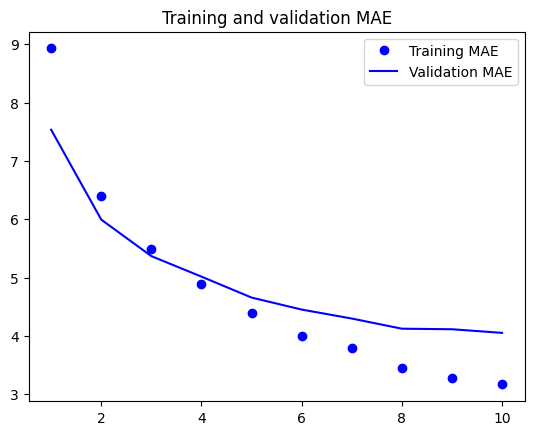

In [35]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [36]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 106.5365 - mae: 8.2181 - val_loss: 26.5853 - val_mae: 4.0474
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 33.3039 - mae: 4.5747 - val_loss: 21.6467 - val_mae: 3.6599
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 27.9425 - mae: 4.2152 - val_loss: 24.5852 - val_mae: 3.9535
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 25.4865 - mae: 4.0532 - val_loss: 21.0066 - val_mae: 3.6134
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 24.1460 - mae: 3.9330 - val_loss: 20.4362 - val_mae: 3.5679
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 22.7870 - mae: 3.7962 - val_loss: 20.1665 - val_mae: 3.5664
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 22.6517 - mae: 3.8031 - val_loss: 20.2798 - val_mae: 3.5904
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 22.2337 - mae: 3.7957 - val_loss: 19.5153 - val_mae: 3.5068
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - los

### A first recurrent baseline

**A simple LSTM-based model**

In [47]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 144.5170 - mae: 9.9995 - val_loss: 127.3999 - val_mae: 9.4576
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 116.2790 - mae: 9.0163 - val_loss: 102.7882 - val_mae: 8.3254
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - loss: 92.3983 - mae: 7.7498 - val_loss: 85.7170 - val_mae: 7.4196
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - loss: 80.1986 - mae: 7.1081 - val_loss: 75.8722 - val_mae: 6.8938
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 71.4405 - mae: 6.6412 - val_loss: 68.6735 - val_mae: 6.5175
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 59.7621 - mae: 6.0004 - val_loss: 62.9342 - val_mae: 6.2047
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 59.8257 - mae: 5.9778 - val_loss: 58.0204 - val_mae: 5.9365
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 52.8495 - mae: 5.5758 - val_loss: 53.7143 - val_mae: 5.6985
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - 

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [38]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [39]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [40]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

**Stacking RNN layers**

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [42]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 132.9286 - mae: 9.5297 - val_loss: 90.2891 - val_mae: 7.7621
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 78.6098 - mae: 7.0670 - val_loss: 62.4111 - val_mae: 6.1998
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 59.2971 - mae: 5.9323 - val_loss: 50.5901 - val_mae: 5.5387
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - loss: 47.0447 - mae: 5.3062 - val_loss: 43.4433 - val_mae: 5.1077
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 41.8769 - mae: 4.9111 - val_loss: 37.9250 - val_mae: 4.7583
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 34.4811 - mae: 4.5009 - val_loss: 33.9769 - val_mae: 4.5074
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 32.8451 - mae: 4.3300 - val_loss: 30.9093 - val_mae: 4.3111
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 28.0643 - mae: 4.0239 - val_loss: 28.4670 - val_mae: 4.1525
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - los

In [43]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [45]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 162s 5s/step - loss: 127.3377 - mae: 9.4277 - val_loss: 84.5605 - val_mae: 7.6103
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - loss: 72.0463 - mae: 6.7977 - val_loss: 58.7580 - val_mae: 6.0779
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - loss: 54.6404 - mae: 5.6842 - val_loss: 51.0599 - val_mae: 5.6272
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - loss: 45.6991 - mae: 5.2039 - val_loss: 44.8027 - val_mae: 5.2405
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - loss: 39.1152 - mae: 4.7188 - val_loss: 40.0434 - val_mae: 4.9501
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - loss: 32.8890 - mae: 4.3195 - val_loss: 36.0874 - val_mae: 4.6983
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - loss: 30.7171 - mae: 4.1766 - val_loss: 33.1119 - val_mae: 4.5117
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - loss: 26.3995 - mae: 3.8917 - val_loss: 30.5161 - val_mae: 4.3367
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - lo

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [46]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - loss: 144.4841 - mae: 9.9286 - val_loss: 114.9050 - val_mae: 9.0693
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 105.4477 - mae: 8.5447 - val_loss: 75.3541 - val_mae: 7.1750
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 70.1526 - mae: 6.7383 - val_loss: 48.5050 - val_mae: 5.3538
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 47.7801 - mae: 5.3983 - val_loss: 37.1068 - val_mae: 4.6165
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 39.4210 - mae: 4.8149 - val_loss: 31.1331 - val_mae: 4.2475
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 29.3844 - mae: 4.1559 - val_loss: 26.6784 - val_mae: 3.9130
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 27.9479 - mae: 4.0142 - val_loss: 23.4908 - val_mae: 3.6832
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 22.8464 - mae: 3.6412 - val_loss: 21.4084 - val_mae: 3.5432
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - l